# Hypothesis Testing Demonstration

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Our dataset comes from Kaggle and contains information about the student, including their identity, education level, and test scores. Let's load it in using pandas and display the first couple of rows. 

In [5]:
scores = pd.read_csv("StudentsPerformance.csv")
scores.head(5)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


The 'test preparation course' column contains the unique values 'none' and 'completed', depending on whether or not the student has completed test preparation. 

In [6]:
test_prep = scores['test preparation course']
test_prep.head(5)

0         none
1    completed
2         none
3         none
4         none
Name: test preparation course, dtype: object

The 'writing score' column contains individual data on student writing  scores

In [7]:
writing_scores = scores["writing score"]
writing_scores.head(5)

0    74
1    88
2    93
3    44
4    75
Name: writing score, dtype: int64

Let's split up the test preparation course column into two series, one with those students who completed test prep and those who didn't

In [8]:
completed_scores = scores[scores['test preparation course'] == 'completed']['reading score']
not_completed_scores = scores[scores['test preparation course'] == 'none']['reading score']

Let's visualize the reading scores between those who completed test prep versus those who didn't. Here are the two histograms:

/Users/anjaliunnithan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/anjaliunnithan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


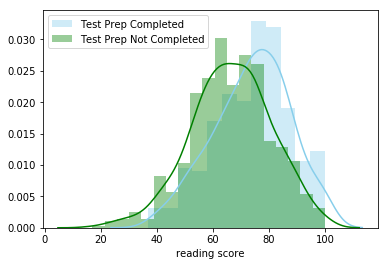

In [15]:
import seaborn as sns
sns.distplot(completed_scores, color="skyblue", label="Test Prep Completed")
sns.distplot(not_completed_scores, color="green", label="Test Prep Not Completed")
plt.legend()

**We would like to see whether whether test preparation was associated with reading scores. To set up our hypothesis test, we can represent the two views of the world using the following null and alternative hypotheses:**

Null hypothesis: In the population, the distribution of reading scores for those who completed test prep is the same for those who didn't complete test prep. The difference in the sample is due to chance.

Alternative hypothesis: In the population, the students who completed test preparation have higher reading scores, on average, than those who didn't complete test prep. The observed difference is "real". This is what would be considered a one-sided alternative hypothesis. (Two-sided would be something like "the distributions are different, not necessarily greater or less than")

We want our test statistic to be the difference between the mean completed score and mean none score based on our original data. The value below is our "observed value" of the test statistic. Large positive values of this statistic will favor the alternative hypothesis. 

In [26]:
observed_difference = np.mean(completed_scores) - np.mean(not_completed_scores)
observed_difference 

7.359586835830754

If there were really no difference between the two distributions in the underlying population, then whether each test preparation was completed or not by the student shouldn't affect their reading score, therefore should make no difference to the average. 

To investigate this more, we will simulate the test statistic under the null hypothesis. Let's shuffle all the reading scores randomly among the students We conduct this random permutation below.

In [17]:
def shuffle(series):
    '''
    Shuffles a series and resets index to preserve shuffle when adding series
    back to DataFrame.
    '''
    return series.sample(frac=1, replace=False).reset_index(drop=True)

In [18]:
scores["Shuffled"] = shuffle(scores["reading score"])
scores.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,Shuffled
0,female,group B,bachelor's degree,standard,none,72,72,74,57
1,female,group C,some college,standard,completed,69,90,88,90
2,female,group B,master's degree,standard,none,90,95,93,84
3,male,group A,associate's degree,free/reduced,none,47,57,44,79
4,male,group C,some college,standard,none,76,78,75,62


In the cell below, we will simulate our test statistic many times and collect the differences in an array.

In [19]:
#Permutation Test
differences = np.array([])

repetitions = 5000
for i in np.arange(repetitions):
    scores["Shuffled"] = shuffle(scores["reading score"])
  
    # Find the difference between the means of two randomly assigned groups
    none = scores[scores['test preparation course'] == 'none']['Shuffled']
    completed = scores[scores['test preparation course'] == 'completed']['Shuffled']
    simulated_difference = np.mean(completed) - np.mean(none)

    differences = np.append(differences, simulated_difference)

Here's a histogram of the simulated difference in means below. We see that majority of the values seem to favor 0:

/Users/anjaliunnithan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


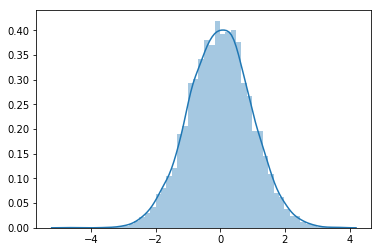

In [20]:
sns.distplot(differences)

Let us now calculate the p-value in order to make a conclusion for this hypothesis test. The p-value in this case would be the proportion of values under the sampling distribution of simulated differences above that are larger or equal to the observed difference. 

In [21]:
p_value = np.count_nonzero(differences >= observed_difference) / repetitions
p_value

0.0

Due to our p-value being less than the threshold of 0.05, we reject the null hypothesis. 

We now should compute a confidence interval in order to provide an interval of estimates for our population parameter. We want to estimate the differences of means of the reading scores for those who did and didn't do test preparation.

We may use the bootstrap sampling distribution to create a confidence interval which we use to estimate the value of the population parameter. We treat our original data as the bootstrap population to perform the bootstrap procedure:

1) Draw a sample with replacement from the test prep students and calculate the mean reading score for these students. We also draw a sample with replacement from the non-test prep students and calculate the mean reading score.

2) Calculate the difference in means.

3) Repeat the above process 10000 times, obtaining 10000 mean differences.

This procedure gives us a empirical sampling distribution of differences in mean reading scores.

In [22]:
def resample(sample):
    return np.random.choice(sample, size=len(sample))

def bootstrap(sample, stat, replicates):
    return np.array([
        stat(resample(sample)) for _ in range(replicates)
    ])

In [23]:
completed_scores = scores[scores['test preparation course'] == 'completed']['reading score']
not_completed_scores = scores[scores['test preparation course'] == 'none']['reading score']

completed_means = bootstrap(completed_scores, np.mean, 10000)
non_completed_means = bootstrap(not_completed_scores, np.mean, 10000)

bootstrap_differences = completed_means - non_completed_means



Here's a histogram of the empirical distribution of the difference in means:

/Users/anjaliunnithan/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


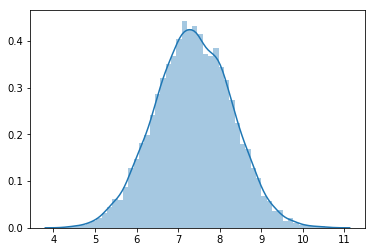

In [24]:
sns.distplot(bootstrap_differences)

In [25]:
# Construct 95% confidence interval from bootstrapping
(np.percentile(bootstrap_differences, 2.5), 
 np.percentile(bootstrap_differences, 97.5))

(5.539379383560447, 9.133983144503036)

This confidence interval allows us to state with 95% confidence that the population mean difference in reading scores is between 5.54 and 9.11.

And that concludes our demo on hypothesis testing! Hope you find this useful in your projects and in the near future! Happy coding :)